### Filterbanks:

In [9]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import librosa
import librosa.display



def plotSignal(input_data):
    # read audio samples
    audio = input_data[1]
    # plot the first 1024 samples
    plt.plot(audio[0:1024])
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    plt.title("Sample Wav")
    # display the plot
    plt.show()

N = 1.0 # N seconds to cut.
#sample_rate, signal = scipy.io.wavfile.read('84-121550-0035.flac')

filename = '84-121550-0035.flac'
#filename = 'OSR_us_000_0010_8k.wav'
filename = '174-84280-0015.flac'
filename = 'ffbb695d_nohash_0.wav'
filename = 'ffbb695d_nohash_0.wav'


signal, sample_rate = librosa.load(filename)
print(signal.shape)
# trim silent edges
signal, _ = librosa.effects.trim(signal)

#print(signal.shape)
#lenSignal = len(signal[:,0])
lenSignal = len(signal)
print(lenSignal)
print(signal.shape)
secondsSignal = lenSignal/sample_rate
#print("sS: ",secondsSignal)
if(secondsSignal< N):
    print("Audio is shorter than the required size. Using entire audio")
else:
    #signal = signal[0:int(N * sample_rate)]  # Keep the first N seconds
    print(signal.shape)


(22050,)
22050
(22050,)
(22050,)


Text(0.5, 1.0, 'Spoken word "Dog", Sampling Rate: 22050')

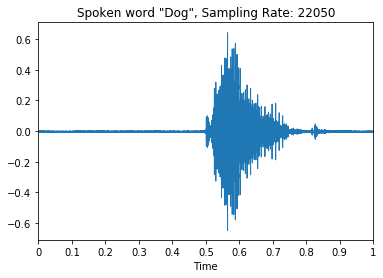

In [10]:
librosa.display.waveplot(signal, sr=sample_rate)
plt.title('Spoken word "Dog", Sampling Rate: '+str(sample_rate))



### Pre-Emphasis<br>
#### First Order high pass filter 
Amplify the high frequencies:<br>
- (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies
- (2) avoid numerical problems during the Fourier transform operation

$y(t) = x(t) - \alpha x(t-1)$

In [10]:
α = 0.97 # Pre-emphasis parameter, usually 0.95 or 0.97
emphasized_signal = np.append(signal[0], signal[1:] - α * signal[:-1])

Text(0.5, 1.0, 'Original signal for the word "dog"')

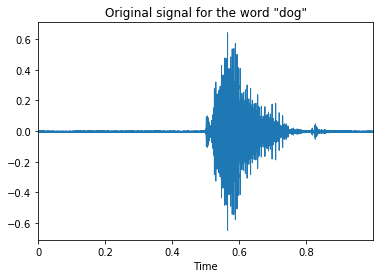

In [15]:
librosa.display.waveplot(signal, sr=sample_rate)
plt.title('Original signal for the word "dog"')

Text(0.5, 1.0, 'Filtered signal for the word "dog"')

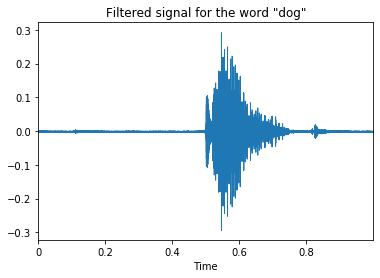

In [11]:
librosa.display.waveplot(emphasized_signal, sr=sample_rate)
plt.title('Filtered signal for the word "dog"')

In [14]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

IndexError: tuple index out of range

### Framing<br>
Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [16]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

### Window<br>
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame.<br>
$w[n] = 0.54 − 0.46 cos ( \frac{2πn}{N − 1} )$

In [17]:
frames *= np.hamming(frame_length)

### Fourier Transformation<br>
Fourier-Transform and Power Spectrum<br><br>
$P = \frac{|FFT(x_i)|^2}{N}$

In [24]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT

pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
print(mag_frames.shape)
plt.plot(mag_frames)
plt.show()

(98, 257)


(98, 257)


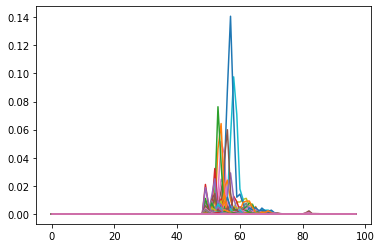

In [26]:
print(pow_frames.shape)
plt.plot(pow_frames)
plt.show()

### Filter Banks<br>
applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz (f) and Mel (m) using the following equations:<br>
$m = 2595 \log_{10} (1 + \frac{f}{700})$<br>
$f = 700 (10^{m/2595} - 1)$<br><br>
$H_m(k) =$
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m + 1) \\
  \end{cases}

In [19]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

## Mean Normalization

(98, 40)

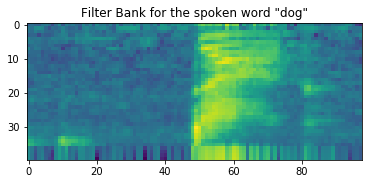

In [22]:
plt.imshow(filter_banks.T)
plt.title('Filter Bank for the spoken word "dog"')
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
filter_banks.shape

(98, 40)


Text(0.5, 1.0, 'Filter Bank')

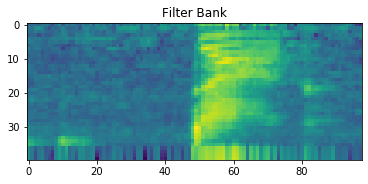

In [21]:
import matplotlib.pyplot as plt # to view graphs
print(filter_banks.shape)
plt.imshow(filter_banks.T)
plt.title('Filter Bank')

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

def audioToFilterBank(signal,sample_rate,α = 0.97, frame_size = 0.025, frame_stride = 0.01,nfilt = 40,low_freq_mel = 0,NFFT = 512):
    """ Converts a raw signal into a filter bank.
    α = High pass filter parameter, usually 0.95 or 0.97"""
     # 
    #High pass filter
    emphasized_signal = np.append(signal[0], signal[1:] - α * signal[:-1])

    # Framing
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]    

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum    

    # Filterbank
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20.0 * np.log10(filter_banks)  # dB  

    #Mean Normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    return filter_banks.T

In [154]:
def plotFilterBank(filter_banks):
    plt.imshow(filter_banks)
    plt.title('Filter Bank')

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import math

def transformAudio(fileName,N = 1.0, trimSilence = True):
    """ N are the seconds to split the audio."""
    signal, sample_rate = librosa.load(filename)

    # trim silent edges
    if trimSilence:
        signal, _ = librosa.effects.trim(signal)

    #lenSignal = len(signal)
    #secondsSignal = lenSignal/sample_rate

    splitSize = int(N * sample_rate)
    
    fb_signal =  audioToFilterBank(signal, sample_rate)
    #fb_signal.shape[1] contains the size of the audio (Seconds*Sampling_rate) but in case of padding, we don't use the theoretic size but the one after applying the filter bank.
    #splitSize
    #Seconds to centiseconds
    splitSize = int(N*100)
    #We only care about complete chunks, the redundant data is then discarded.
    N_chunks = int(fb_signal.shape[1] / splitSize)
    
    audios_transformed = []
    print("sr",sample_rate)
    for i in range(N_chunks):
        signal_chunk = fb_signal[: , i*splitSize:((i+1)*splitSize)]  # Keep the first N seconds
        #fb_signal =  audioToFilterBank(signal_chunk, sample_rate)
        audios_transformed.append(signal_chunk)
    return audios_transformed

filename = '84-121550-0035.flac'

fb_signal = transformAudio(filename)
print(np.max(fb_signal[0]))
print(np.min(fb_signal[0]))
print(fb_signal[0].shape)
plotFilterBank(fb_signal[1])

NoBackendError: 

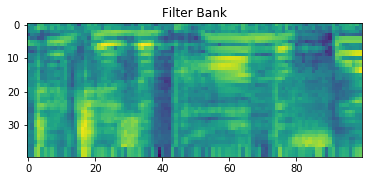

In [156]:
plotFilterBank(fb_signal[2])


In [157]:
plotFilterBank(fb_signal[6])

1

In [158]:
filename = '84-121550-0034.flac'
fb_signal = transformAudio(filename)
print(np.max(fb_signal[0]))
print(np.min(fb_signal[0]))
plotFilterBank(fb_signal[0])

sr 22050
66.72449006624308
-172.10556604005797


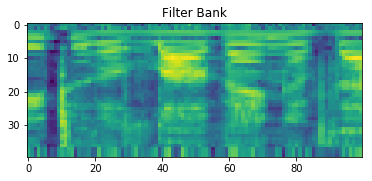

In [159]:
plotFilterBank(fb_signal[4])

In [160]:
#filename = 'OSR_us_000_0010_8k.wav'
filename = '174-84280-0015.flac'

fb_signal = transformAudio(filename)
print(np.max(fb_signal[0]))
print(np.min(fb_signal[0]))
plotFilterBank(fb_signal[0])

sr 22050
63.8450199849087
-158.79320439875687


In [161]:
plotFilterBank(fb_signal[5])

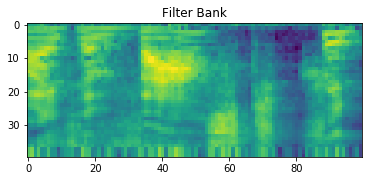

In [162]:
plotFilterBank(fb_signal[8])

N_chunks 8
254.83622643092968
147.40031043747956


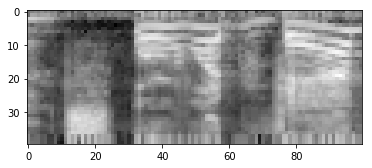

In [204]:
def plotImage(img):
    imgplot = plt.imshow(img, cmap='gray')

def transformAudio(fileName,N = 1.0, trimSilence = True):
    """ N are the seconds to split the audio."""
    signal, sample_rate = librosa.load(filename)

    # trim silent edges
    if trimSilence:
        signal, _ = librosa.effects.trim(signal)

    #lenSignal = len(signal)
    #secondsSignal = lenSignal/sample_rate

    splitSize = int(N * sample_rate)
    
    fb_signal =  audioToFilterBank(signal, sample_rate)
    fb_signal = fb_signal#*-1.0
    #Rescale between 0 and 255.

    #fb_signal /= np.max(np.abs(fb_signal),axis=0)
    #fb_signal *= ((255.0)/fb_signal.max())
    #Normalize now to values between 0 and 255
    fb_signal = np.interp(fb_signal, (fb_signal.min(), fb_signal.max()), (0, 255))

    #fb_signal.shape[1] contains the size of the audio (Seconds*Sampling_rate) but in case of padding, we don't use the theoretic size but the one after applying the filter bank.
    #splitSize
    #Seconds to centiseconds
    splitSize = int(N*100)
    #We only care about complete chunks, the redundant data is then discarded.
    #N_chunks = int(fb_signal.shape[1] / splitSize)
    N_chunks = math.ceil(fb_signal.shape[1] / splitSize)
    print("N_chunks",N_chunks)
    audios_transformed = []
    Nfilters, Nsamples = fb_signal.shape
    for i in range(N_chunks):
        
        if( ((i+1)*splitSize) < Nsamples):
            signal_chunk = fb_signal[: , i*splitSize:((i+1)*splitSize)]  # Keep the first N seconds
        else:
            missingN = Nsamples- (i*splitSize)
            partialChunk = fb_signal[: , i*splitSize:]
            meanOfFilters = np.mean(partialChunk,1) # Mean in the y axis

            NrightMissing = splitSize - missingN

            #The missing part will be filled with the mean of each filter along the whole rest of the filter.
            fillingChunk = np.vstack([meanOfFilters]*NrightMissing).T

            signal_chunk = np.concatenate((partialChunk,fillingChunk), axis=1)
        audios_transformed.append(signal_chunk)
    return audios_transformed

filename = '84-121550-0035.flac'

fb_signal = transformAudio(filename)

print(np.max(fb_signal[1]))
print(np.min(fb_signal[1]))

#plotFilterBank(fb_signal[1])
plotImage(fb_signal[1])

In [ ]:
### The part to fill:

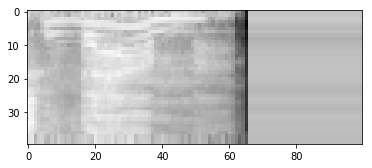

In [205]:
plotImage(fb_signal[7])

sr 22050


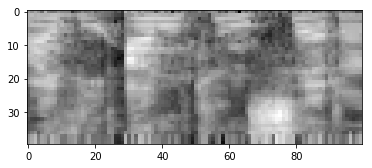

In [177]:
filename = '174-84280-0015.flac'

fb_signal = transformAudio(filename)
plotImage(fb_signal[3])

sr 22050


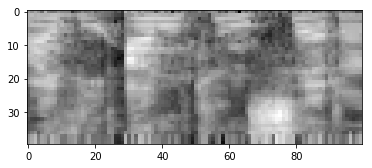

In [178]:
fb_signal = transformAudio(filename)
plotImage(fb_signal[3])

### Command "up"

N_chunks 1


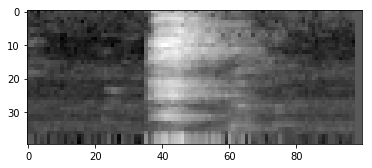

In [209]:
filename = 'ffd2ba2f_nohash_3.wav'

fb_signal = transformAudio(filename)
plotImage(fb_signal[0])

(128, 44)


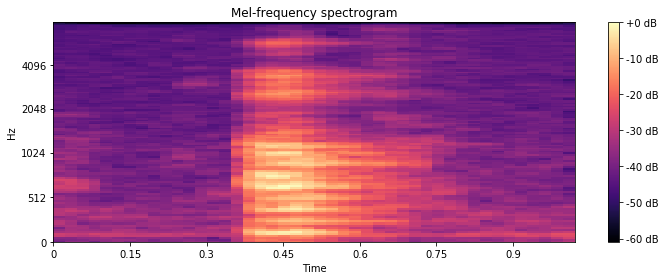

In [218]:
import matplotlib.pyplot as plt
y, sr = librosa.load("ffd2ba2f_nohash_3.wav")
#librosa.feature.melspectrogram(y=y, sr=sr)
#Power 1= energy
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000,power=1)

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

### Reference:
https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

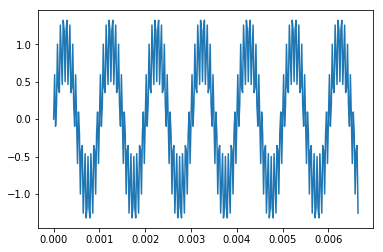

In [4]:
#https://os.mbed.com/cookbook/FIR-Filter	

from numpy import sin, arange, pi
from scipy.signal import lfilter, firwin
from pylab import figure, plot, grid, show
 
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------
# 320 samples of (1000Hz + 15000 Hz) at 48 kHz
sample_rate = 48000.
nsamples = 320
 
F_1KHz = 1000.
A_1KHz = 1.0
 
F_15KHz = 15000.
A_15KHz = 0.5
 
t = arange(nsamples) / sample_rate
signal = A_1KHz * sin(2*pi*F_1KHz*t) + A_15KHz*sin(2*pi*F_15KHz*t)
signal.shape
plot(t, signal)
show()

In [5]:
 
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.
 
# The cutoff frequency of the filter: 6KHz
cutoff_hz = 6000.0
 
# Length of the filter (number of coefficients, i.e. the filter order + 1) 28 + 1
numtaps = 29
 
# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)
 
# Use lfilter to filter the signal with the FIR filter
filtered_signal = lfilter(fir_coeff, 1.0, signal)
filtered_signal.shape
plot(t, filtered_signal)

In [6]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------
 
# The first N-1 samples are "corrupted" by the initial conditions
warmup = numtaps - 1
 
# The phase delay of the filtered signal
delay = (warmup / 2) / sample_rate
 
figure(1)
# Plot the original signal
plot(t, signal)
 
# Plot the filtered signal, shifted to compensate for the phase delay
plot(t-delay, filtered_signal, 'r-')
 
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[warmup:]-delay, filtered_signal[warmup:], 'g', linewidth=4)
 
grid(True)
 
show()
 


In [8]:
#------------------------------------------------
# Print values
#------------------------------------------------
def print_values(label, values):
    var = "float32_t %s[%d]" % (label, len(values))
    print ("%-30s = {%s}" % (var, ', '.join(["%+.10f" % x for x in values])))
 
print_values('signal', signal)
print_values('fir_coeff', fir_coeff)
print_values('filtered_signal', filtered_signal)


float32_t signal[320]          = {+0.0000000000, +0.5924659585, -0.0947343455, +0.1913417162, +1.0000000000, +0.4174197128, +0.3535533906, +1.2552931065, +0.8660254038, +0.4619397663, +1.3194792169, +1.1827865776, +0.5000000000, +1.1827865776, +1.3194792169, +0.4619397663, +0.8660254038, +1.2552931065, +0.3535533906, +0.4174197128, +1.0000000000, +0.1913417162, -0.0947343455, +0.5924659585, -0.0000000000, -0.5924659585, +0.0947343455, -0.1913417162, -1.0000000000, -0.4174197128, -0.3535533906, -1.2552931065, -0.8660254038, -0.4619397663, -1.3194792169, -1.1827865776, -0.5000000000, -1.1827865776, -1.3194792169, -0.4619397663, -0.8660254038, -1.2552931065, -0.3535533906, -0.4174197128, -1.0000000000, -0.1913417162, +0.0947343455, -0.5924659585, +0.0000000000, +0.5924659585, -0.0947343455, +0.1913417162, +1.0000000000, +0.4174197128, +0.3535533906, +1.2552931065, +0.8660254038, +0.4619397663, +1.3194792169, +1.1827865776, +0.5000000000, +1.1827865776, +1.3194792169, +0.4619397663, +0.866

In [13]:
import matplotlib.pyplot as plt
import scipy

#y, sr = librosa.load(librosa.util.example_audio_file(), offset=30,duration=0.020)
y = signal                
print(signal.shape)     
sr = sample_rate
a = librosa.lpc(y, 2)
y_hat = scipy.signal.lfilter([0] + -1*a[1:], [1], y)
plt.figure()
plt.plot(y)
plt.plot(y_hat, linestyle='--')
plt.legend(['y', 'y_hat'])
plt.title('LP Model Forward Prediction')
plt.show()


(22050,)
